# Importation data

## Imports

In [2]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Baseball
import statsapi
from datetime import datetime, timedelta
import time

# Set Style of Viz
sns.set_style("darkgrid")
# sns.set_palette(palette='dark:#5A9_r')
# Magic lines
%matplotlib inline
%load_ext autoreload
%autoreload 2

## MLB API

## Extraction de la data

In [3]:
def get_team_stats_before_game(team_id, game_date):
    try:
        # Date de la veille pour avoir les stats pré-match
        date_obj = datetime.strptime(game_date, '%Y-%m-%d')
        previous_day = (date_obj - timedelta(days=1)).strftime('%Y-%m-%d')
        season = str(date_obj.year)  # Ajout de l'année

        # Stats d'équipe
        team_stats = statsapi.get('team_stats', {
            'teamId': team_id,
            'season': season,  # Ajout du paramètre season
            'stats': 'season',
            'group': 'hitting',
            'date': previous_day
        })

        team_pitching = statsapi.get('team_stats', {
            'teamId': team_id,
            'season': season,  # Ajout du paramètre season
            'stats': 'season',
            'group': 'pitching',
            'date': previous_day
        })

        # Classement
        standings = statsapi.get('standings', {
            'leagueId': '103,104',
            'date': previous_day
        })

        return {
            'stats': team_stats,
            'pitching': team_pitching,
            'standings': standings
        }
    except Exception as e:
        print(f"Erreur pour team {team_id} à la date {game_date}: {str(e)}")
        return None

def collect_matches_data(start_year, end_year):
    all_games_data = []

    for year in range(start_year, end_year + 1):
        print(f"Récupération des données pour {year}...")

        # Récupérer tous les matchs de la saison
        schedule = statsapi.schedule(
            start_date=f'{year}-03-28',
            end_date=f'{year}-10-01'
        )

        print(f"Nombre de matchs trouvés : {len(schedule)}")

        for i, game in enumerate(schedule):
            try:
                game_date = game['game_date']
                home_team = game['home_id']
                away_team = game['away_id']

                # Afficher la progression
                print(f"Traitement du match {i+1}/{len(schedule)} : {home_team} vs {away_team} le {game_date}")

                # Récupérer les stats des deux équipes avant le match
                home_stats = get_team_stats_before_game(home_team, game_date)
                time.sleep(1)  # Pause pour éviter de surcharger l'API
                away_stats = get_team_stats_before_game(away_team, game_date)
                time.sleep(1)

                if home_stats and away_stats:
                    game_data = {
                        'game_id': game['game_id'],
                        'date': game_date,
                        'home_team': home_team,
                        'away_team': away_team,
                        'home_score': game.get('home_score', None),
                        'away_score': game.get('away_score', None),
                        'home_win': game.get('home_score', 0) > game.get('away_score', 0) if 'home_score' in game else None,
                        'home_stats': home_stats,
                        'away_stats': away_stats
                    }
                    all_games_data.append(game_data)

                    # Sauvegarde intermédiaire tous les 50 matchs
                    if (i + 1) % 50 == 0:
                        temp_df = pd.DataFrame(all_games_data)
                        temp_df.to_csv(f'mlb_games_2024_temp_{i+1}.csv', index=False)

            except Exception as e:
                print(f"Erreur lors du traitement du match: {str(e)}")
                continue

    return all_games_data

# Exécuter la collecte pour 2024
data = collect_matches_data(2017,2023)

# Convertir en DataFrame
df = pd.DataFrame(data)

# Afficher un aperçu des données
print("\nAperçu des données collectées:")
print(df.head())
print("\nColonnes disponibles:")
print(df.columns.tolist())

# Sauvegarder les données
df.to_csv('mlb_games_2017_2023.csv', index=False)

Récupération des données pour 2017...
Nombre de matchs trouvés : 2538
Traitement du match 1/2538 : 142 vs 139 le 2017-03-28
Traitement du match 2/2538 : 144 vs 110 le 2017-03-28
Traitement du match 3/2538 : 146 vs 117 le 2017-03-28
Traitement du match 4/2538 : 121 vs 138 le 2017-03-28
Traitement du match 5/2538 : 115 vs 140 le 2017-03-28
Traitement du match 6/2538 : 113 vs 119 le 2017-03-28
Traitement du match 7/2538 : 119 vs 135 le 2017-03-28
Traitement du match 8/2538 : 112 vs 137 le 2017-03-28
Traitement du match 9/2538 : 118 vs 145 le 2017-03-28
Traitement du match 10/2538 : 158 vs 114 le 2017-03-28
Traitement du match 11/2538 : 108 vs 133 le 2017-03-28
Traitement du match 12/2538 : 136 vs 109 le 2017-03-28
Traitement du match 13/2538 : 134 vs 111 le 2017-03-28
Traitement du match 14/2538 : 143 vs 141 le 2017-03-28
Traitement du match 15/2538 : 120 vs 146 le 2017-03-28
Traitement du match 16/2538 : 147 vs 116 le 2017-03-28
Traitement du match 17/2538 : 138 vs 120 le 2017-03-29
Trai

### Concat DF 2017-2023 to 2024

In [43]:
# Lire tous les fichiers
df_2017_2023 = pd.read_csv('raw/mlb_games_2017_2023.csv')
df_2024 = pd.read_csv('raw/mlb_games_2024.csv')

# Vérifier que les colonnes sont identiques
print("Colonnes 2017-2023:", df_2017_2023.columns.tolist())
print("Colonnes 2024:", df_2024.columns.tolist())

# Concaténer
df = pd.concat([df_2017_2023, df_2024], axis=0, ignore_index=True)

df.to_csv('mlb_games_2017_2024_final.csv', index=False)

# Afficher quelques infos sur le dataset final
print("\nNombre total de matchs:", len(df))

Colonnes 2017-2023: ['game_id', 'date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_win', 'home_stats', 'away_stats']
Colonnes 2024: ['game_id', 'date', 'home_team', 'away_team', 'home_score', 'away_score', 'home_win', 'home_stats', 'away_stats']

Nombre total de matchs: 18530


### Extraction statistiques

In [44]:
def extract_stats_features(df):
    # Conversion en datetime pour tri chronologique
    df['date'] = pd.to_datetime(df['date'])

    # Ajouter numéro de match dans la saison pour chaque équipe
    df['season'] = df['date'].dt.year

    # Créer numéro de match pour équipe domicile et extérieur
    home_game_number = df.groupby(['home_team', 'season']).cumcount() + 1
    away_game_number = df.groupby(['away_team', 'season']).cumcount() + 1

    def get_season_period(game_number):
        if game_number <= 20:
            return 'early'
        elif game_number <= 100:
            return 'mid'
        else:
            return 'late'

    df['home_game_number'] = home_game_number
    df['away_game_number'] = away_game_number
    df['home_season_period'] = home_game_number.apply(get_season_period)
    df['away_season_period'] = away_game_number.apply(get_season_period)

    # Extraction des stats
    stats_dict_list = []
    for _, row in df.iterrows():
        if isinstance(row['home_stats'], str):
            home_stats = eval(row['home_stats'])
            away_stats = eval(row['away_stats'])
        else:
            home_stats = row['home_stats']
            away_stats = row['away_stats']

        home_hitting_stats = home_stats['stats']['stats'][0]['splits'][0]['stat']
        home_pitching_stats = home_stats['pitching']['stats'][0]['splits'][0]['stat']
        away_hitting_stats = away_stats['stats']['stats'][0]['splits'][0]['stat']
        away_pitching_stats = away_stats['pitching']['stats'][0]['splits'][0]['stat']

        # Créer les préfixes pour toutes les stats
        stats_dict = {}

        # Home hitting stats
        for key, value in home_hitting_stats.items():
            stats_dict[f'home_hitting_{key}'] = value

        # Home pitching stats
        for key, value in home_pitching_stats.items():
            stats_dict[f'home_pitching_{key}'] = value

        # Away hitting stats
        for key, value in away_hitting_stats.items():
            stats_dict[f'away_hitting_{key}'] = value

        # Away pitching stats
        for key, value in away_pitching_stats.items():
            stats_dict[f'away_pitching_{key}'] = value

        stats_dict_list.append(stats_dict)

    # Créer DataFrame des stats
    stats_df = pd.DataFrame(stats_dict_list, index=df.index)

    # Combiner avec les infos de base
    final_df = pd.concat([
        df[['game_id', 'date', 'home_team', 'away_team', 'home_win',
            'home_game_number', 'away_game_number',
            'home_season_period', 'away_season_period', 'season']],
        stats_df
    ], axis=1)

    return final_df

# Utilisation
final_df = extract_stats_features(df)
print("\nColonnes dans le DataFrame final:")
print(final_df.columns.tolist())


Colonnes dans le DataFrame final:
['game_id', 'date', 'home_team', 'away_team', 'home_win', 'home_game_number', 'away_game_number', 'home_season_period', 'away_season_period', 'season', 'home_hitting_gamesPlayed', 'home_hitting_groundOuts', 'home_hitting_airOuts', 'home_hitting_runs', 'home_hitting_doubles', 'home_hitting_triples', 'home_hitting_homeRuns', 'home_hitting_strikeOuts', 'home_hitting_baseOnBalls', 'home_hitting_intentionalWalks', 'home_hitting_hits', 'home_hitting_hitByPitch', 'home_hitting_avg', 'home_hitting_atBats', 'home_hitting_obp', 'home_hitting_slg', 'home_hitting_ops', 'home_hitting_caughtStealing', 'home_hitting_stolenBases', 'home_hitting_stolenBasePercentage', 'home_hitting_groundIntoDoublePlay', 'home_hitting_numberOfPitches', 'home_hitting_plateAppearances', 'home_hitting_totalBases', 'home_hitting_rbi', 'home_hitting_leftOnBase', 'home_hitting_sacBunts', 'home_hitting_sacFlies', 'home_hitting_babip', 'home_hitting_groundOutsToAirouts', 'home_hitting_catcher

In [45]:
final_df.shape

(18530, 190)

In [48]:
final_df.to_csv('clean/mlb_games_2017_2024.csv', index=False)

## Check Data

In [49]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18530 entries, 0 to 18529
Columns: 190 entries, game_id to away_pitching_sacFlies
dtypes: bool(1), datetime64[ns](1), int64(134), object(54)
memory usage: 26.7+ MB


## Vérification data en double et NA

In [30]:
final_df.duplicated().sum()/len(final_df)

0.0

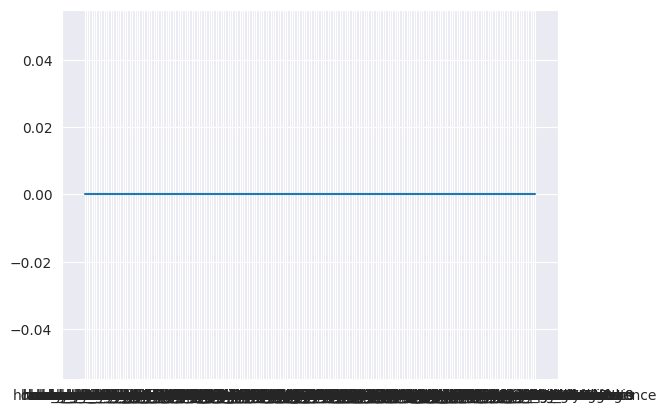

In [36]:
plt.plot(final_df.isna().sum())

## Features numériques ou catégoriques

In [34]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18530 entries, 0 to 18529
Columns: 190 entries, game_id to away_pitching_sacFlies
dtypes: bool(1), datetime64[ns](1), int64(134), object(54)
memory usage: 26.7+ MB


### Data catégorique

In [40]:
cat_cols = final_df.select_dtypes(include='object').columns
final_df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18530 entries, 0 to 18529
Data columns (total 54 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   home_season_period                  18530 non-null  object
 1   away_season_period                  18530 non-null  object
 2   home_hitting_avg                    18530 non-null  object
 3   home_hitting_obp                    18530 non-null  object
 4   home_hitting_slg                    18530 non-null  object
 5   home_hitting_ops                    18530 non-null  object
 6   home_hitting_stolenBasePercentage   18530 non-null  object
 7   home_hitting_babip                  18530 non-null  object
 8   home_hitting_groundOutsToAirouts    18530 non-null  object
 9   home_hitting_atBatsPerHomeRun       18530 non-null  object
 10  home_pitching_avg                   18530 non-null  object
 11  home_pitching_obp                   18530 non-null  ob

In [ ]:
feat_categorical_nunique = final_df.select_dtypes(include='object').nunique()

feat_categorical_nunique.hist();

In [25]:
df['home_season_period'].unique(), df['away_season_period'].unique()

(array(['early', 'mid'], dtype=object), array(['early', 'mid'], dtype=object))

In [26]:
df['home_season_period'] = df['home_season_period'].replace({'mid': 1, 'early': 0})
df['away_season_period'] = df['away_season_period'].replace({'mid': 1, 'early': 0})

/tmp/ipykernel_310521/898003463.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['home_season_period'] = df['home_season_period'].replace({'mid': 1, 'early': 0})
/tmp/ipykernel_310521/898003463.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['away_season_period'] = df['away_season_period'].replace({'mid': 1, 'early': 0})


In [27]:
df['home_season_period'].unique(), df['away_season_period'].unique()

(array([0, 1]), array([0, 1]))

### Date

In [35]:
df['date'] = pd.to_datetime(df['date'])

In [37]:
df['home_win'] = df['home_win'].astype(int)

In [42]:
df.to_csv('clean/mlb_games_2017_2024.csv', index=False)

# Recherche de nouvelles stats

## Check stats disponibles sur les dataframes importés

In [6]:
df = pd.read_csv("raw/mlb_games_2024.csv")
df

,game_id,date,home_team,away_team,home_score,away_score,home_win,home_stats,away_stats
0,747060,2024-03-28,110,108,11,3,True,{'stats': {'copyright': 'Copyright 2025 MLB Ad...,{'stats': {'copyright': 'Copyright 2025 MLB Ad...
1,746737,2024-03-28,113,120,8,2,True,{'stats': {'copyright': 'Copyright 2025 MLB Ad...,{'stats': {'copyright': 'Copyright 2025 MLB Ad...
2,745445,2024-03-28,135,137,6,4,True,{'stats': {'copyright': 'Copyright 2025 MLB Ad...,{'stats': {'copyright': 'Copyright 2025 MLB Ad...
3,746165,2024-03-28,119,138,7,1,True,{'stats': {'copyright': 'Copyright 2025 MLB Ad...,{'stats': {'copyright': 'Copyright 2025 MLB Ad...
4,745116,2024-03-28,139,141,2,8,False,{'stats': {'copyright': 'Copyright 2025 MLB Ad...,{'stats': {'copyright': 'Copyright 2025 MLB Ad...
...,...,...,...,...,...,...,...,...,...
2466,747064,2024-09-30,144,121,3,0,True,{'stats': {'copyright': 'Copyright 2025 MLB Ad...,{'stats': {'copyright': 'Copyright 2025 MLB Ad...
2467,775345,2024-10-01,117,116,1,3,False,{'stats': {'copyright': 'Copyright 2025 MLB Ad...,{'stats': {'copyright': 'Copyright 2025 MLB Ad...
2468,775343,2024-10-01,110,118,0,1,False,{'stats': {'copyright': 'Copyright 2025 MLB Ad...,{'stats': {'copyright': 'Copyright 2025 MLB Ad...
2469,775340,2024-10-01,158,121,4,8,False,{'stats': {'copyright': 'Copyright 2025 MLB Ad...,{'stats': {'copyright': 'Copyright 2025 MLB Ad...


In [7]:
# Prenons le premier match
sample_game = df.iloc[0]
home_stats = eval(sample_game['home_stats'])

print("STATS OFFENSIVES:")
print("-----------------")
hitting_stats = home_stats['stats']['stats'][0]['splits'][0]['stat']
for key in sorted(hitting_stats.keys()):
    print(f"{key}: {hitting_stats[key]}")

print("\nSTATS PITCHING:")
print("--------------")
pitching_stats = home_stats['pitching']['stats'][0]['splits'][0]['stat']
for key in sorted(pitching_stats.keys()):
    print(f"{key}: {pitching_stats[key]}")

print("\nSTANDINGS:")
print("---------")
standings = home_stats['standings']
print(standings)

STATS OFFENSIVES:
-----------------
airOuts: 1581
atBats: 5567
atBatsPerHomeRun: 23.69
avg: .250
babip: .288
baseOnBalls: 489
catchersInterference: 5
caughtStealing: 25
doubles: 262
gamesPlayed: 162
groundIntoDoublePlay: 71
groundOuts: 1286
groundOutsToAirouts: 0.81
hitByPitch: 64
hits: 1391
homeRuns: 235
intentionalWalks: 14
leftOnBase: 1108
numberOfPitches: 24121
obp: .315
ops: .750
plateAppearances: 6176
rbi: 759
runs: 786
sacBunts: 6
sacFlies: 45
slg: .435
stolenBasePercentage: .797
stolenBases: 98
strikeOuts: 1359
totalBases: 2424
triples: 33

STATS PITCHING:
--------------
airOuts: 1518
atBats: 5482
avg: .238
balks: 8
baseOnBalls: 481
battersFaced: 6071
blownSaves: 21
catchersInterference: 1
caughtStealing: 31
completeGames: 0
doubles: 262
earnedRuns: 632
era: 3.94
gamesFinished: 162
gamesPitched: 162
gamesPlayed: 162
gamesStarted: 162
groundIntoDoublePlay: 86
groundOuts: 1335
groundOutsToAirouts: 0.88
hitBatsmen: 53
hitByPitch: 53
hits: 1303
hitsPer9Inn: 8.13
holds: 111
homeRuns

In [12]:
# Voir les valeurs possibles pour sky et windDirection
print("Types de ciel:")
print(statsapi.meta('sky'))

print("\nDirections du vent:")
print(statsapi.meta('windDirection'))

# Essayons aussi avec un match spécifique en utilisant game_contextMetrics
game_info = statsapi.get('game_contextMetrics', {'gamePk': 747060})
print("\nInformations du match:")
print(game_info)

Types de ciel:
[{'code': 'Clear', 'description': 'Clear'}, {'code': 'Cloudy', 'description': 'Cloudy'}, {'code': 'Dome', 'description': 'Dome'}, {'code': 'Drizzle', 'description': 'Drizzle'}, {'code': 'Overcast', 'description': 'Overcast'}, {'code': 'Partly Cloudy', 'description': 'Partly Cloudy'}, {'code': 'Rain', 'description': 'Rain'}, {'code': 'Roof Closed', 'description': 'Roof Closed'}, {'code': 'Snow', 'description': 'Snow'}, {'code': 'Sunny', 'description': 'Sunny'}]

Directions du vent:
[{'code': 'Calm', 'description': 'Calm'}, {'code': 'In From CF', 'description': 'In From CF'}, {'code': 'In From LF', 'description': 'In From LF'}, {'code': 'In From RF', 'description': 'In From RF'}, {'code': 'L To R', 'description': 'L To R'}, {'code': 'None', 'description': 'None'}, {'code': 'Out To CF', 'description': 'Out To CF'}, {'code': 'Out To LF', 'description': 'Out To LF'}, {'code': 'Out To RF', 'description': 'Out To RF'}, {'code': 'R To L', 'description': 'R To L'}, {'code': 'Vari

In [15]:
def collect_additional_info(df):
    # Créer un DataFrame pour les infos additionnelles
    additional_info = []

    total_games = len(df)
    for idx, game_id in enumerate(df['game_id'], 1):
        print(f"Traitement match {idx}/{total_games}: {game_id}")
        try:
            # Info basique du match
            game_info = statsapi.get('game_contextMetrics', {'gamePk': game_id})

            # IDs des lanceurs
            home_pitcher_id = game_info['game']['teams']['home']['probablePitcher']['id']
            away_pitcher_id = game_info['game']['teams']['away']['probablePitcher']['id']

            # Stats des lanceurs
            print(f"Récupération stats lanceur domicile: {home_pitcher_id}")
            home_pitcher_stats = statsapi.get('person_stats', {
                'personId': home_pitcher_id,
                'group': 'pitching',
                'stats': 'season',
                'season': str(pd.to_datetime(df[df['game_id'] == game_id]['date'].iloc[0]).year)
            })

            print(f"Récupération stats lanceur extérieur: {away_pitcher_id}")
            away_pitcher_stats = statsapi.get('person_stats', {
                'personId': away_pitcher_id,
                'group': 'pitching',
                'stats': 'season',
                'season': str(pd.to_datetime(df[df['game_id'] == game_id]['date'].iloc[0]).year)
            })

            # On prend d'abord un match pour voir la structure des stats
            if idx == 1:
                print("\nStructure des stats lanceur:")
                print(home_pitcher_stats)

            info = {
                'game_id': game_id,
                'day_night': game_info['game']['dayNight'],
                'home_probable_pitcher_id': home_pitcher_id,
                'away_probable_pitcher_id': away_pitcher_id,
            }

            additional_info.append(info)
            time.sleep(1)

        except Exception as e:
            print(f"Erreur pour le match {game_id}: {str(e)}")
            continue

    # Test sur quelques matchs d'abord
    return additional_info

# Test sur un petit échantillon
sample_df = df.head(2)  # juste 2 matchs pour tester
result = collect_additional_info(sample_df)
print("\nRésultats:")
print(result)

Traitement match 1/2: 747060
Récupération stats lanceur domicile: 669203
Erreur pour le match 747060: Missing required path parameter {gamePk}
Traitement match 2/2: 746737
Récupération stats lanceur domicile: 593423
Erreur pour le match 746737: Missing required path parameter {gamePk}

Résultats:
[]


In [16]:
def collect_additional_info(df):
    additional_info = []

    total_games = len(df)
    for idx, game_id in enumerate(df['game_id'], 1):
        print(f"Traitement match {idx}/{total_games}: {game_id}")
        try:
            # Info basique du match
            game_info = statsapi.get('game_contextMetrics', {'gamePk': game_id})

            # Info des lanceurs
            game_data = statsapi.get('game', {'gamePk': game_id})
            if idx == 1:
                print("\nStructure game_data:")
                print(game_data)

            info = {
                'game_id': game_id,
                'day_night': game_info['game']['dayNight'],
                'home_probable_pitcher_id': game_info['game']['teams']['home']['probablePitcher']['id'],
                'away_probable_pitcher_id': game_info['game']['teams']['away']['probablePitcher']['id'],
            }

            additional_info.append(info)
            time.sleep(1)

        except Exception as e:
            print(f"Erreur pour le match {game_id}: {str(e)}")
            continue

    return additional_info

# Test sur un petit échantillon
sample_df = df.head(2)
result = collect_additional_info(sample_df)
print("\nRésultats:")
print(result)

Traitement match 1/2: 747060

Structure game_data:
{'copyright': 'Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt', 'gamePk': 747060, 'link': '/api/v1.1/game/747060/feed/live', 'metaData': {'wait': 10, 'timeStamp': '20240328_215753', 'gameEvents': ['strikeout', 'game_finished'], 'logicalEvents': ['midInning', 'countChange', 'count13', 'gameStateChangeToGameOver']}, 'gameData': {'game': {'pk': 747060, 'type': 'R', 'doubleHeader': 'N', 'id': '2024/03/28/anamlb-balmlb-1', 'gamedayType': 'P', 'tiebreaker': 'N', 'gameNumber': 1, 'calendarEventID': '14-747060-2024-03-28', 'season': '2024', 'seasonDisplay': '2024'}, 'datetime': {'dateTime': '2024-03-28T19:05:00Z', 'originalDate': '2024-03-28', 'officialDate': '2024-03-28', 'dayNight': 'day', 'time': '3:05', 'ampm': 'PM'}, 'status': {'abstractGameState': 'Final', 'codedGameState': 'F', 'detailedState': 'Final', 'statusCode': 'F'